In [2]:
# IMPORT STATEMENTS
import astropy.units as u
from astropy.coordinates.sky_coordinate import SkyCoord
from astropy.units import Quantity
from astroquery.gaia import Gaia

#%matplotlib inline
import matplotlib.pyplot as plt
import math
import numpy as np
import treecorr

# Suppress warnings. Comment this out if you wish to see the warning messages
import warnings
warnings.filterwarnings('ignore')

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [3]:
from astroquery.gaia import Gaia
tables = Gaia.load_tables(only_names=True)
for table in (tables):
    print (table.get_qualified_name())

INFO: Retrieving tables... [astroquery.utils.tap.core]
INFO: Parsing tables... [astroquery.utils.tap.core]
INFO: Done. [astroquery.utils.tap.core]
external.external.apassdr9
external.external.gaiadr2_geometric_distance
external.external.gaiaedr3_distance
external.external.galex_ais
external.external.ravedr5_com
external.external.ravedr5_dr5
external.external.ravedr5_gra
external.external.ravedr5_on
external.external.sdssdr13_photoprimary
external.external.skymapperdr1_master
external.external.skymapperdr2_master
external.external.tmass_xsc
public.public.hipparcos
public.public.hipparcos_newreduction
public.public.hubble_sc
public.public.igsl_source
public.public.igsl_source_catalog_ids
public.public.tycho2
public.public.dual
tap_config.tap_config.coord_sys
tap_config.tap_config.properties
tap_schema.tap_schema.columns
tap_schema.tap_schema.key_columns
tap_schema.tap_schema.keys
tap_schema.tap_schema.schemas
tap_schema.tap_schema.tables
gaiaedr3.gaiaedr3.gaia_source
gaiaedr3.gaiaedr3.ag

# Extract Gaia Data and Show spatial slices

In [4]:
job = Gaia.launch_job_async("SELECT gaiaedr3.gaia_source.phot_g_mean_mag, gaia_source.ra,gaia_source.dec, gaia_source.parallax, gaia_source.pm,gaia_source.phot_g_mean_mag, gaia_source.dr2_radial_velocity, gaia_source.pmra, gaia_source.pmdec, gaia_source.bp_rp \
FROM gaiaedr3.gaia_source \
WHERE gaiaedr3.gaia_source.parallax>10 \
AND gaiaedr3.gaia_source.parallax/gaiaedr3.gaia_source.parallax_error >10 \
AND gaiaedr3.gaia_source.dr2_radial_velocity IS NOT NULL"\
, dump_to_file=True)

#AND gaiaedr3.gaia_source.phot_g_mean_mag + 5 - 5*log10(1000/gaiaedr3.gaia_source.parallax) > 5\

print (job)

Jobid: 1620078594714O
Phase: COMPLETED
Owner: None
Output file: async_20210503214954.vot
Results: None


In [5]:
r = job.get_results()
print(len(r))

72633


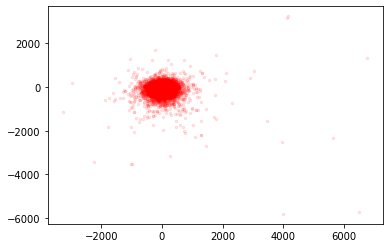

In [6]:

plt.scatter(r['pmra'], r['pmdec'], color='r', alpha=0.1,s = 6)
#plt.xlim(-60,80)
#plt.ylim(-120,30)

plt.show()

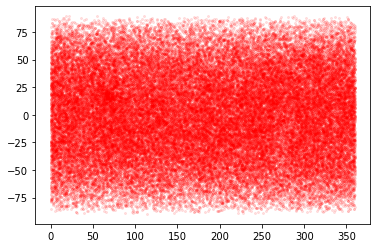

In [7]:
plt.scatter(r['ra'], r['dec'], color='r', alpha=0.1, s = 4)

plt.show()

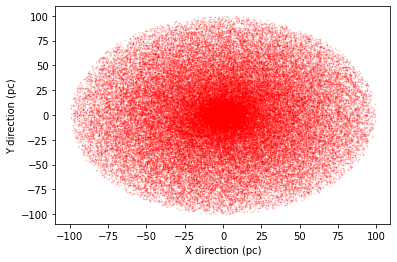

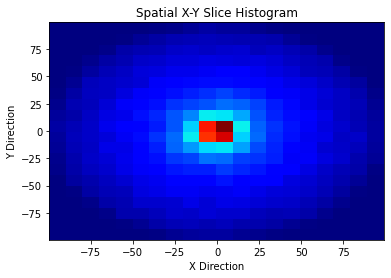

In [8]:
#plt.rcParams.update({
#    "text.usetex": True,
#    "font.family": "sans-serif",
#    "font.sans-serif": ["Helvetica"]})
racos = np.cos(r['ra'])
rasin = np.sin(r['ra'])
deccos = np.cos(r['dec'])
decsin = np.sin(r['dec'])
dist = 1000*np.reciprocal(r['parallax'])
xcoord = np.multiply(dist,np.multiply(racos,deccos))
ycoord = np.multiply(dist,np.multiply(deccos,rasin))
fig = plt.figure()
plt.scatter(xcoord, ycoord, color='r', alpha=0.2, s=0.5)
#plt.title(r"Spatial x-y slice of Gaia Data")
plt.xlabel(r"X direction (pc)")
plt.ylabel(r"Y direction (pc)")
#fig.set_rasterized(True)
plt.savefig("spatial_xy.pdf")
plt.show()

fig2 = plt.figure()
plt.hist2d(xcoord, ycoord, bins = 20, cmap=plt.cm.jet)
plt.title(r"Spatial X-Y Slice Histogram")
plt.xlabel(r"X Direction")
plt.ylabel(r"Y Direction")
fig2.set_rasterized(True)
plt.savefig("spatial_xy_hist.eps")

plt.show()

In [9]:
from astropy import units as u
import astropy.coordinates as astcoord
dec = np.array(r['dec'])
ra = np.array(r['ra'])
pmra = np.array(r['pmra'])
pmdec = np.array(r['pmdec'])
hrv = np.array(r['dr2_radial_velocity'])
dist = np.array(dist)
bp_rp = np.array(r['bp_rp'])
# an astropy skycoordinate object
c1 = astcoord.ICRS(ra=ra*u.degree, dec=dec*u.degree, distance=dist*u.pc, pm_ra_cosdec=pmra*u.mas/u.yr, pm_dec=pmdec*u.mas/u.yr, radial_velocity=hrv*u.km/u.s)
gc1 = c1.transform_to(astcoord.Galactocentric)
(x,y,z) = (gc1.x.value,gc1.y.value,gc1.z.value)
(vx,vy,vz) = (gc1.v_x.value,gc1.v_y.value,gc1.v_z.value)
print(np.count_nonzero(x<-8222))
print(np.count_nonzero(x>-8022))
print(np.count_nonzero(y>100))
print(np.count_nonzero(y<-100))
print(np.count_nonzero(z<-80))
print(np.count_nonzero(z>121))
print(max(z))


0
0
0
0
0
0
120.37229723581746


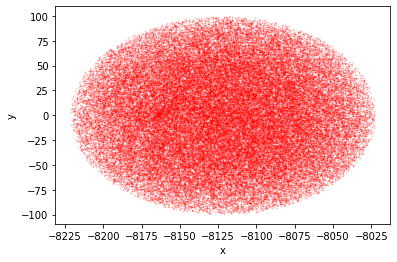

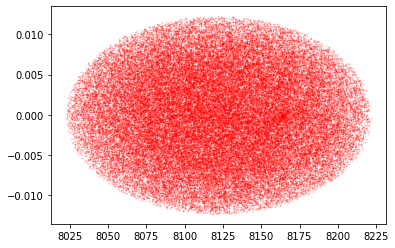

In [11]:
plt.scatter(x,y, color = 'r', alpha = 0.2, s=0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

#theta = np.arctan2(y,x)
theta = []
for i in range(len(y)):
  theta.append(math.atan(y[i]/x[i]))
R = np.sqrt(x*x + y*y)
plt.scatter(R,theta, color = 'r', alpha = 0.2, s = 0.5)
plt.show()

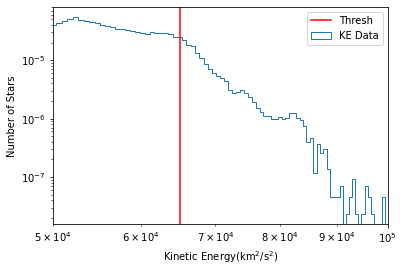

In [12]:
hist_x = (vx*vx)+(vy*vy)+(vz*vz)
n_bins = 200
#fig, axs = plt.subplots(1, 1, figsize =(6, 4), tight_layout = True) 
fig = plt.figure()
#hist_x_final = hist_x/(np.linalg.norm(hist_x))
plt.hist(hist_x, bins = "auto", histtype="step", density=True, label = 'KE Data')
plt.xlim(50000, 100000)
#plt.xlim(0, 90000)
plt.xscale('log')
plt.yscale('log')
plt.axvline(x = 6.5e4, c = 'r', label = 'Thresh')
plt.xlabel(r"Kinetic Energy(km$^2$/s$^2$)")
plt.ylabel(r"Number of Stars")
#plt.title("KE Histogram")
#fig.set_rasterized(True)
plt.legend()
plt.savefig("KE_hist.pdf")
plt.show()


# CMD Diagram

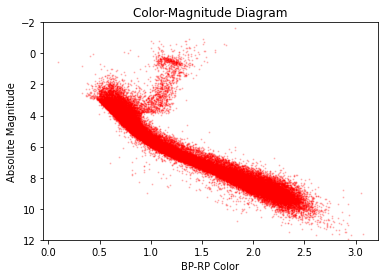

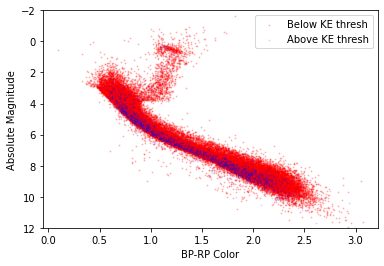

In [13]:
app_mag = np.array(r['phot_g_mean_mag'])
parallax = np.array(r['parallax'])
abs_mag = app_mag + 5 - 5*np.log10(1000/parallax) 
xcoord = bp_rp
ycoord = abs_mag

plt.scatter(xcoord, ycoord, color='r', alpha=0.2, s = 1)
plt.xlabel("BP-RP Color")
plt.ylabel("Absolute Magnitude")
plt.ylim(12,-2)
plt.title("Color-Magnitude Diagram")
plt.show()

xcoord = []
ycoord = []
xcoord_KE = []
ycoord_KE = []

for i in range(len(abs_mag)):
  if hist_x[i]>7e4:
    xcoord_KE.append(bp_rp[i])
    ycoord_KE.append(abs_mag[i])
  else:
    xcoord.append(bp_rp[i])
    ycoord.append(abs_mag[i])

fig = plt.figure()
plt.scatter(xcoord,ycoord,color = 'r', alpha = 0.2, s = 1)
plt.scatter(xcoord_KE, ycoord_KE, color='b', alpha=0.1, s = 1)
plt.xlabel("BP-RP Color")
plt.ylabel("Absolute Magnitude")
plt.ylim(12,-2)
#plt.title(r"Color-Magnitude Diagram")
plt.legend(["Below KE thresh","Above KE thresh"])
plt.savefig("HR_diagram.pdf")
plt.show()
#plt.save(cmd_diagram.eps)

# Bkg Generation and 2 PCF

In [14]:
# background data assuming uniform distribution
from numpy import random
s = len(r)
x_pcf_highKE = []
y_pcf_highKE = []
z_pcf_highKE = []
vx_highKE = []
vy_highKE = []
vz_highKE = []
x_bkg = []
y_bkg = []
z_bkg = []

for i in range(s):
  if hist_x[i]>7e4:
    x_pcf_highKE.append(x[i])
    y_pcf_highKE.append(y[i])
    z_pcf_highKE.append(z[i])
    vx_highKE.append(vx[i])
    vy_highKE.append(vy[i])
    vz_highKE.append(vz[i])

s_highKE = len(x_pcf_highKE)

while len(x_bkg)<3*s:
  x_samp = 200*random.rand() - 100
  y_samp = 200*random.rand() - 100
  z_samp = 200*random.rand() - 100
  if math.sqrt(x_samp*x_samp + y_samp*y_samp + z_samp*z_samp) < 100:
    x_bkg.append(x_samp-8122)
    y_bkg.append(y_samp)
    z_bkg.append(z_samp+20)

N = len(x_bkg)
N = N**(1/3)
x_bkg = np.array(x_bkg)
y_bkg = np.array(y_bkg)
z_bkg = np.array(z_bkg)
ID = x_bkg*x_bkg + N*y_bkg*y_bkg + N*N*z_bkg*z_bkg
#x_bkg = [x for _,x in sorted(zip(ID,x_bkg))]
#y_bkg = [x for _,x in sorted(zip(ID,y_bkg))]
#z_bkg = [x for _,x in sorted(zip(ID,z_bkg))]
a = np.asarray([x_bkg, y_bkg, z_bkg])
np.savetxt("test.bin", a, delimiter=",")
print(N)
print(N**(1/3))
print(60.1753**3)


cat_data_all = treecorr.Catalog(x = x, y = y, z = z)
cat_bkg_all = treecorr.Catalog(x = x_bkg, y = y_bkg, z = z_bkg)

cat_data_highKE = treecorr.Catalog(x=x_pcf_highKE, y=y_pcf_highKE, z=z_pcf_highKE)
cat_bkg_highKE = treecorr.Catalog(x = x_bkg[1:2*s_highKE], y = y_bkg[1:2*s_highKE], z = z_bkg[1:2*s_highKE])

60.17532054613143
3.918677026182507
217898.77680318477


In [15]:
dd_highKE = treecorr.NNCorrelation(min_sep=1., max_sep=200., nbins= 25) # math.sqrt(s))
rr_highKE = treecorr.NNCorrelation(min_sep=1., max_sep=200., nbins= 25) #math.sqrt(s))
dr_highKE = treecorr.NNCorrelation(min_sep=1., max_sep=200., nbins= 25) #math.sqrt(s))
dd_highKE.process(cat_data_highKE)
rr_highKE.process(cat_bkg_highKE)
dr_highKE.process(cat_data_highKE, cat_bkg_highKE)
xi_highKE, varxi_highKE = dd_highKE.calculateXi(rr_highKE,dr_highKE)

In [16]:
dd_all = treecorr.NNCorrelation(min_sep=1., max_sep=200., nbins= 25) # math.sqrt(s))
rr_all = treecorr.NNCorrelation(min_sep=1., max_sep=200., nbins= 25) #math.sqrt(s))
dr_all = treecorr.NNCorrelation(min_sep=1., max_sep=200., nbins= 25) #math.sqrt(s))
dd_all.process(cat_data_all)
rr_all.process(cat_bkg_all)
dr_all.process(cat_data_all, cat_bkg_all)
xi_all, varxi_all = dd_all.calculateXi(rr_all,dr_all)

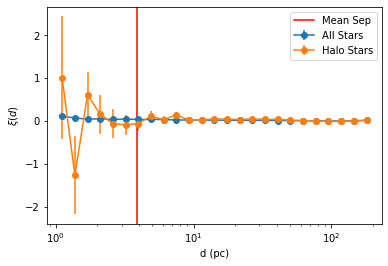

In [17]:
fig = plt.figure()
plt.errorbar(dd_all.rnom, xi_all, yerr = np.sqrt(varxi_all), fmt='-o', label = 'All Stars')
plt.errorbar(dd_highKE.rnom, xi_highKE, yerr = np.sqrt(varxi_highKE), fmt='-o', label = 'Halo Stars')
#plt.title(r'2PCF using the LS Estimator on log scale')
plt.ylabel(r'$\xi(d)$')
plt.xlabel(r'd (pc)')
plt.xscale('log')
#plt.yscale('log')
#plt.xlim(10,200)
plt.axvline(x = 3.86, c='r', label = 'Mean Sep')
plt.legend()
#plt.xlim(0,20)
#plt.ylim(-.5,.5)
#fig.set_rasterized(True)
plt.savefig("2PCF_log.pdf")
plt.show()

# Inverse Sample Transform

72633
72633


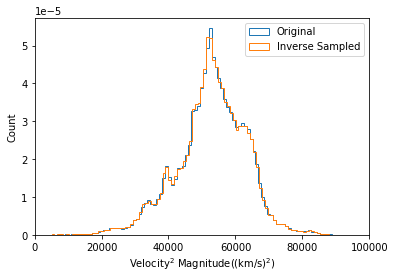

72633
217899


In [18]:
from scipy import integrate
hist_E = vx*vx + vy*vy + vz*vz
hist_E = np.sqrt(hist_E)
Nbs = 100
# set the bin edges for the histogram
#bin_edges = np.linspace(min(hist_E),max(hist_E),Nbs)
# get a histogram of this array, make sure to normalize!
#(hist_E,bin_edges) = np.histogram(hist_E,bins=bin_edges,density=True)
#hist_E = np.array([0] + list(hist_E))

energies_sorted = np.sort(hist_E)
Ndata = len(energies_sorted)

# now that you have a histogram, you can take the cumulative sum
#cum_histE = integrate.cumtrapz(hist_E,)
cum_histE = np.arange(Ndata)/(1.*Ndata)
cum_histE_norm = cum_histE[-1]
cum_histE /= cum_histE_norm

sample_size = int(3*72633)
rndm_no = np.random.random(sample_size)
print(len(cum_histE))
print(len(energies_sorted))
r_energies = np.interp(rndm_no, cum_histE, energies_sorted)

hist_x = (vx*vx)+(vy*vy)+(vz*vz)
fig = plt.figure()
plt.hist(hist_x, bins = 200, histtype="step", density=True, label = 'Original')
#plt.xlim(50000, 100000)
plt.xlim(0, 100000)
plt.xlabel(r'Velocity$^2$ Magnitude((km/s)$^2$)')
plt.ylabel('Count')
#plt.xscale('log')
#plt.yscale('log')
#plt.title("KE Histogram")

plt.hist(np.square(r_energies), bins=200, histtype = 'step', density=True, label = 'Inverse Sampled')
#fig.set_rasterized(True)
plt.legend()
plt.savefig('inverse_sample.pdf')

plt.show()

print(len(hist_x))
print(len(r_energies))

26.739026801374923


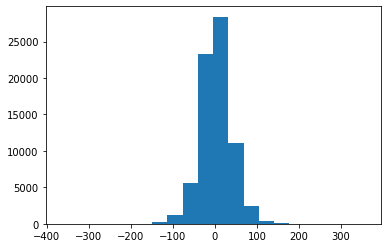

In [19]:
size = len(r_energies)
print(min(r_energies))
from pyhull.voronoi import VoronoiTess
#theta_energies = 2*math.pi*np.random.random(sample_size)
#phi_energies = np.arccos(1-2*(np.random.random(sample_size)))
#v_x = r_energies*np.sin(phi_energies)*np.cos(theta_energies)
#v_y = r_energies*np.sin(phi_energies)*np.sin(theta_energies)
#v_z = r_energies*np.cos(phi_energies)

r_energies_bkg = r_energies
theta_energies_bkg = 2*math.pi*np.random.random(sample_size)
phi_energies_bkg = np.arccos(1-2*(np.random.random(sample_size)))
v_x_bkg = r_energies*np.sin(phi_energies_bkg)*np.cos(theta_energies_bkg)
v_y_bkg = r_energies*np.sin(phi_energies_bkg)*np.sin(theta_energies_bkg)
v_z_bkg = r_energies*np.cos(phi_energies_bkg)


x_bkg = np.array(x_bkg)
y_bkg = np.array(y_bkg)
z_bkg = np.array(z_bkg)

x_highKE = np.array(x_pcf_highKE)
y_highKE = np.array(y_pcf_highKE)
z_highKE = np.array(z_pcf_highKE)

vx_highKE = np.array(vx_highKE)
vy_highKE = np.array(vy_highKE)
vz_highKE = np.array(vz_highKE)

theta = np.arctan(y/x)
v_r = vx*np.cos(theta) + vy*np.sin(theta)
v_T = -vx*np.sin(theta) + vy*np.cos(theta)
v_z = vz
R = np.sqrt(x*x + y*y)
phi = np.arctan(R/z)

theta_bkg = np.arctan(y_bkg/x_bkg)
v_r_bkg = v_x_bkg*np.cos(theta_bkg) + v_y_bkg*np.sin(theta_bkg)
v_T_bkg = -v_x_bkg*np.sin(theta_bkg) + v_y_bkg*np.cos(theta_bkg)
R_bkg = np.sqrt(x_bkg*x_bkg + y_bkg*y_bkg)
phi_bkg = np.arctan(R_bkg/z_bkg)

theta_highKE = np.arctan(y_highKE/x_highKE)
v_r_highKE = vx_highKE*np.cos(theta_highKE) + vy_highKE*np.sin(theta_highKE)
v_T_highKE = -vx_highKE*np.sin(theta_highKE) + vy_highKE*np.cos(theta_highKE)
v_z_highKE = vz_highKE
R_highKE = np.sqrt(x_highKE*x_highKE + y_highKE*y_highKE)
phi_highKE = np.arctan(R_highKE/z_highKE)

##############################################
#TESTING
##############################################
#r_test = np.ones(sample_size)
#print(max(theta))
#fig = plt.figure()
#ax = Axes3D(fig)

# Express the mesh in the cartesian system.
#X = r_test*np.sin(phi)*np.cos(theta)
#Y = r_test*np.sin(phi)*np.sin(theta)
#Z = r_test*np.cos(phi)

# Plot the surface.
#ax.scatter(X, Y, Z)
#plt.show()
################################################
#print(theta)
#plt.scatter(R,theta, color = 'r', alpha = 0.5)
#plt.show()
plt.hist(v_r, bins=20)
plt.show()

# Action Angles Calculation

In [20]:
from galpy.actionAngle import estimateDeltaStaeckel
from galpy.potential import MWPotential2014,NFWPotential, HernquistPotential

In [21]:
len(R)

72633

In [ ]:
from galpy import orbit
s = len(R)
orbits = []
for i in range(s):
  #if i == 1000 or i ==5000 or i == 100 or i == 10000:
   # print(i)
  o = orbit.Orbit([R[i]*u.pc, v_r[i]*u.km/u.s, v_T[i]*u.km/u.s, z[i]*u.pc, v_z[i]*u.km/u.s, theta[i]*u.rad])
  ts= np.linspace(0.,100.,1001)
  o.integrate(ts,MWPotential2014)
  orbits.append(o)

#print(estimateDeltaStaeckel(MWPotential2014,o.R(ts),o.z(ts)))

In [ ]:
print(orbits[70000])

In [ ]:
np.savetxt("orbitsR", orbits[0].R(ts))
np.savetxt("orbitsz", orbits[0].z(ts))

np.savez("orbitsR", [orbits[i].R(ts) for i in range(s)])

In [ ]:
np.savez("orbitsz", [orbits[i].z(ts) for i in range(s)])

# Start Here if data saved

In [ ]:
orbitsz = np.load('/content/drive/MyDrive/orbitsz.npz')
orbitsR = np.load("/content/drive/MyDrive/orbitsR.npz")
orbitsR = orbitsR['arr_0']
orbitsz = orbitsz['arr_0']

In [ ]:
print(len(orbitsR))

72633


In [ ]:
#import gala
#w = gala.dynamics
#gala.get_staeckel_fudge_delta(gala.potential.potential.BovyMWPotential2014,)

In [ ]:
#deltas = []
#s=len(orbitsR)
#for i in range(s):
#  deltas.append(estimateDeltaStaeckel(MWPotential2014,orbitsR[i], orbitsz[i]))

In [ ]:
np.savetxt("deltas", deltas)

In [23]:
# Calculate Staeckel Potentials and put in values to get action-angles
from galpy.actionAngle import actionAngleStaeckel
aAS_bkg= actionAngleStaeckel(pot=MWPotential2014,delta=0.4,fixed_quad=True) #c=True is the default
aAS= actionAngleStaeckel(pot=MWPotential2014,delta=0.4,fixed_quad=True) #c=True is the default

In [24]:
jr, lz, jz, omegar, omegaphi, omegaz, thetar, thetaphi, thetaz = aAS.actionsFreqsAngles(R*u.pc, v_r*u.km/u.s, v_T*u.km/u.s, z*u.pc, v_z*u.km/u.s, theta*u.rad)
jr_highKE, lz_highKE, jz_highKE, omegar_highKE, omegaphi_highKE, omegaz_highKE, thetar_highKE, thetaphi_highKE, thetaz_highKE = aAS.actionsFreqsAngles(R_highKE*u.pc, v_r_highKE*u.km/u.s, v_T_highKE*u.km/u.s, z_highKE*u.pc, v_z_highKE*u.km/u.s, theta_highKE*u.rad)

In [25]:
jr_bkg, lz_bkg, jz_bkg, omegar_bkg, omegaphi_bkg, omegaz_bkg, thetar_bkg, thetaphi_bkg, thetaz_bkg = aAS.actionsFreqsAngles(R_bkg*u.pc, v_r_bkg*u.km/u.s, v_T_bkg*u.km/u.s, z_bkg*u.pc, v_z_bkg*u.km/u.s,theta_bkg*u.rad)

In [29]:
# Phi
length = len(thetaphi)
for i in range(length):
  if thetaphi[i]<math.pi and thetaphi[i]>0:
    thetaphi[i] = thetaphi[i] + math.pi
  else:
    thetaphi[i] = thetaphi[i] - math.pi

length = len(thetaphi_bkg)
for i in range(length):
  if thetaphi_bkg[i]<math.pi and thetaphi_bkg[i]>0:
    thetaphi_bkg[i] = thetaphi_bkg[i] + math.pi
  else:
    thetaphi_bkg[i] = thetaphi_bkg[i] - math.pi

length = len(thetaphi_highKE)
for i in range(length):
  if thetaphi_highKE[i]<math.pi and thetaphi_highKE[i]>0:
    thetaphi_highKE[i] = thetaphi_highKE[i] + math.pi
  else:
    thetaphi_highKE[i] = thetaphi_highKE[i] - math.pi

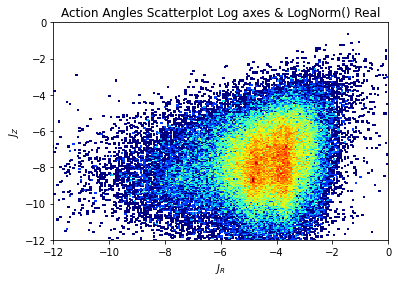

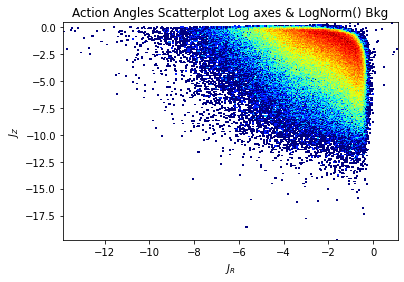

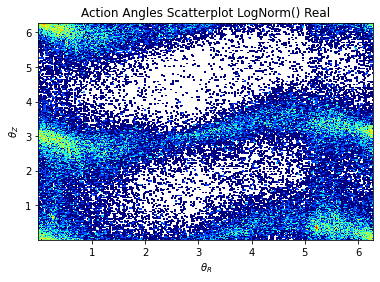

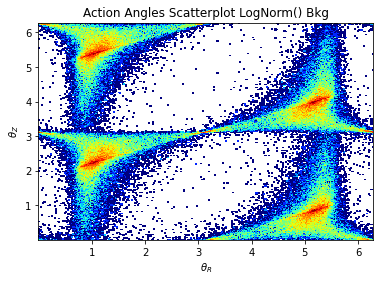

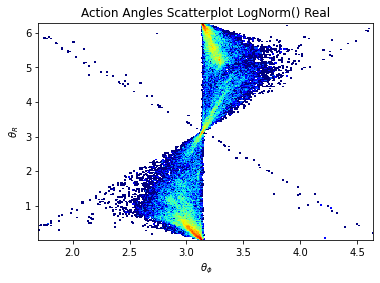

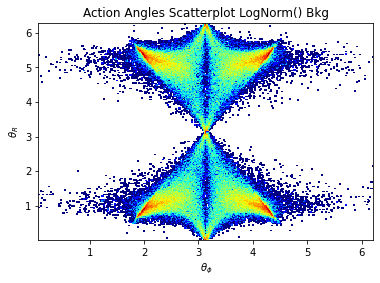

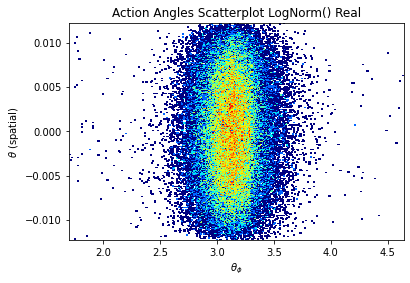

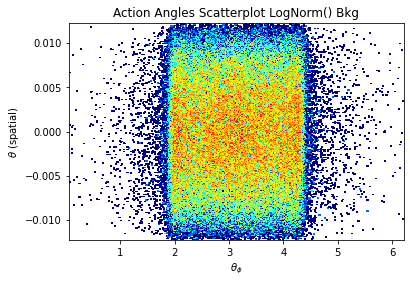

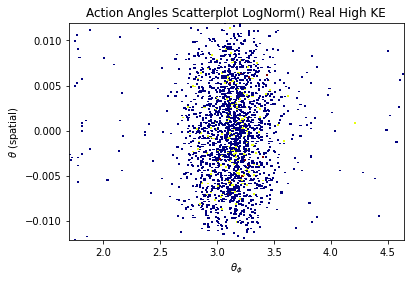

In [30]:
# PLOTTING ACTION ANGLE HISTOGRAMS 
from matplotlib.colors import LogNorm
fig = plt.figure()
plt.hist2d(np.log(jr), np.log(jz), bins=(300, 300), cmap=plt.cm.jet, norm=LogNorm())
plt.xlabel(r'$J_R$')
plt.ylabel(r'$J_Z$')
plt.ylim(-12,0)
plt.xlim(-12,0)
plt.title("Action Angles Scatterplot Log axes & LogNorm() Real" )
#fig.set_rasterized(True)
plt.savefig("jr_vs_jz.pdf", bbox_inches = "tight")
plt.show()

fig = plt.figure()
plt.hist2d(np.log(jr_bkg), np.log(jz_bkg), bins=(300, 300), cmap=plt.cm.jet, norm=LogNorm())
plt.xlabel(r'$J_R$')
plt.ylabel(r'$J_Z$')
#plt.ylim(-12,0)
#plt.xlim(-12,0)
plt.title("Action Angles Scatterplot Log axes & LogNorm() Bkg" )
fig.set_rasterized(True)
plt.savefig("jr_bkg_vs_jz_bkg.pdf", bbox_inches = "tight")
plt.show()

fig = plt.figure()
plt.hist2d(thetar, thetaz, bins=(300, 300), cmap=plt.cm.jet, norm=LogNorm())
plt.xlabel(r'$\theta_R$')
plt.ylabel(r'$\theta_Z$')
#plt.ylim(-10,2)
#plt.xlim(-10,2)
plt.title("Action Angles Scatterplot LogNorm() Real" )
fig.set_rasterized(True)
plt.savefig("thetaR_vs_thetaZ.pdf", bbox_inches = "tight")
plt.show()

fig = plt.figure()
plt.hist2d(thetar_bkg, thetaz_bkg, bins=(300, 300), cmap=plt.cm.jet, norm=LogNorm())
plt.xlabel(r'$\theta_R$')
plt.ylabel(r'$\theta_Z$')
#plt.ylim(-10,2)
#plt.xlim(-10,2)
plt.title("Action Angles Scatterplot LogNorm() Bkg" )
fig.set_rasterized(True)
plt.savefig("thetaR_bkg_vs_thetaZ_bkg.pdf", bbox_inches = "tight")
plt.show()

fig = plt.figure()
plt.hist2d(thetaphi, thetar, bins=(300, 300), cmap=plt.cm.jet, norm=LogNorm())
plt.xlabel(r'$\theta_{\phi}$')
plt.ylabel(r'$\theta_R$')
#plt.ylim(-10,2)
#plt.xlim(-10,2)
plt.title("Action Angles Scatterplot LogNorm() Real" )
fig.set_rasterized(True)
plt.savefig("thetaphi_vs_thetaR.pdf", bbox_inches = "tight")
plt.show()

fig = plt.figure()
plt.hist2d(thetaphi_bkg, thetar_bkg, bins=(300, 300), cmap=plt.cm.jet, norm=LogNorm())
plt.xlabel(r'$\theta_{\phi}$')
plt.ylabel(r'$\theta_R$')
#plt.ylim(-10,2)
#plt.xlim(-10,2)
plt.title("Action Angles Scatterplot LogNorm() Bkg" )
fig.set_rasterized(True)
plt.savefig("thetaphi_bkg_vs_thetaR_bkg.pdf", bbox_inches = "tight")
plt.show()

fig = plt.figure()
plt.hist2d(thetaphi, theta, bins=(300, 300), cmap=plt.cm.jet, norm=LogNorm())
plt.xlabel(r'$\theta_{\phi}$')
plt.ylabel(r'$\theta$ (spatial)')
#plt.ylim(-10,2)
#plt.xlim(-10,2)
plt.title("Action Angles Scatterplot LogNorm() Real" )
fig.set_rasterized(True)
plt.savefig("thetaphi_vs_theta.pdf",bbox_inches = "tight")
plt.show()

fig = plt.figure()
plt.hist2d(thetaphi_bkg, theta_bkg, bins=(300, 300), cmap=plt.cm.jet, norm=LogNorm())
plt.xlabel(r'$\theta_{\phi}$')
plt.ylabel(r'$\theta$ (spatial)')
#plt.ylim(-10,2)
#plt.xlim(-10,2)
plt.title("Action Angles Scatterplot LogNorm() Bkg" )
fig.set_rasterized(True)
plt.savefig("thetaphi_bkg_vs_theta_bkg.pdf", bbox_inches = "tight")
plt.show()

fig = plt.figure()
plt.hist2d(thetaphi_highKE, theta_highKE, bins=(300, 300), cmap=plt.cm.jet, norm=LogNorm())
plt.xlabel(r'$\theta_{\phi}$')
plt.ylabel(r'$\theta$ (spatial)')
#plt.ylim(-10,2)
#plt.xlim(-10,2)
plt.title("Action Angles Scatterplot LogNorm() Real High KE" )
fig.set_rasterized(True)
plt.savefig("thetaphi_vs_theta_highKE.pdf", bbox_inches = "tight")
plt.show()

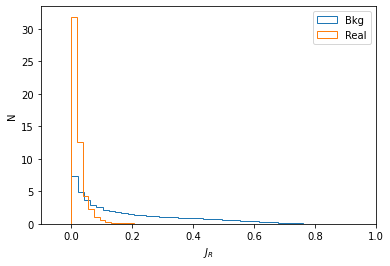

In [ ]:
plt.hist(jr_bkg, bins=150, histtype = 'step', density=True, label = 'Bkg')
plt.hist(jr, bins=150, histtype = 'step', density=True, label = 'Real')
plt.xlim(-0.1, 1.0)
plt.xlabel(r'$J_R$')
plt.ylabel('N')
plt.legend()
plt.show()

In [ ]:
len(jr)
print(size)

217899


In [ ]:
points_real = []
size = len(jr)
for i in range(size):
  pt = [thetar[i], thetaphi[i], thetaz[i]]
  points_real.append(pt)

points_bkg = []
size = len(thetar_bkg)
for i in range(size):
  pt = [thetar_bkg[i], thetaphi_bkg[i], thetaz_bkg[i]]
  points_bkg.append(pt)


points_highKE = []
size = len(thetaphi_highKE)
for i in range(size):
  pt = [thetar_highKE[i], thetaphi_highKE[i], thetaz_highKE[i]]
  points_highKE.append(pt)

In [ ]:
# v = VoronoiTess(points)
np.savetxt("thetar_highKE", thetar_highKE)
np.savetxt("thetaphi_highKE", thetaphi_highKE)
np.savetxt("thetaz_highKE", thetaz_highKE)
np.savetxt("thetar_bkg", thetar_bkg)
np.savetxt("thetaphi_bkg", thetaphi_bkg)
np.savetxt("thetaz_bkg", thetaz_bkg)
np.savetxt("thetar_real", thetar)
np.savetxt("thetaphi_real", thetaphi)
np.savetxt("thetaz_real", thetaz)


In [ ]:
thetar_highKE = np.loadtxt("thetar_highKE")
thetaz_highKE = np.loadtxt("thetaz_highKE")
thetaphi_highKE = np.loadtxt("thetaphi_highKE")
points_highKE = []
size = len(thetaphi_highKE)
for i in range(size):
  pt = [thetar_highKE[i], thetaphi_highKE[i], thetaz_highKE[i]]
  points_highKE.append(pt)

In [ ]:
from scipy.spatial import Voronoi, voronoi_plot_2d, ConvexHull
#vor_real = Voronoi(points_real)
#vor_bkg = Voronoi(points_bkg)
#v_highKE = Voronoi(points_highKE)

In [ ]:
# Find Cell volumes by constructing convex hulls
def voronoi_volumes(points):
    v = Voronoi(points)
    vol = np.zeros(v.npoints)
    for i, reg_num in enumerate(v.point_region):
        if reg_num == len(points):
          continue
        indices = v.regions[reg_num]
        
        if -1 in indices: # some regions can be opened
            vol[reg_num] = np.inf
        else:
            vol[reg_num] = ConvexHull(v.vertices[indices]).volume
    return vol

In [ ]:
len(points_bkg)

217899

In [ ]:
# Collect cell volumes and number of infs for BKG
vor_vol_temp = voronoi_volumes(points_bkg)
vor_vol_bkg = []
thetaphi_bkg_new = []
thetar_bkg_new = []
thetaz_bkg_new = []
s = len(vor_vol_temp)-1
count_inf = 0
for i in range(s):
  if (not math.isinf(vor_vol_temp[i])) and vor_vol_temp[i]!=0.0:
    vor_vol_bkg.append(vor_vol_temp[i])
    thetaphi_bkg_new.append(thetaphi_bkg[i])
    thetar_bkg_new.append(thetar_bkg[i])
    thetaz_bkg_new.append(thetaz_bkg[i])
  if math.isinf(vor_vol_temp[i]):
    count_inf = count_inf+1


In [ ]:
# Collect cell volumes and number of infs for highKE
vor_vol_temp = voronoi_volumes(points_highKE)
vor_vol_highKE = []
thetaphi_highKE_new = []
thetar_highKE_new = []
thetaz_highKE_new = []
s = len(vor_vol_temp)-1
count_inf = 0
for i in range(s):
  if (not math.isinf(vor_vol_temp[i])) and vor_vol_temp[i]!=0.0:
    vor_vol_highKE.append(vor_vol_temp[i])
    thetaphi_highKE_new.append(thetaphi_bkg[i])
    thetar_highKE_new.append(thetar_highKE[i])
    thetaz_highKE_new.append(thetaz_highKE[i])
  if math.isinf(vor_vol_temp[i]):
    count_inf = count_inf+1
print(max(vor_vol_highKE))

812168.7391495919


In [ ]:
# Collect cell volumes and number of infs for full real data
vor_vol_temp = voronoi_volumes(points_real)
vor_vol_real = []
thetaphi_real_new = []
thetar_real_new = []
thetaz_real_new = []
s = len(vor_vol_temp)-1
count_inf = 0
for i in range(s):
  if (not math.isinf(vor_vol_temp[i])) and vor_vol_temp[i]!=0.0:
    vor_vol_real.append(vor_vol_temp[i])
    thetaphi_real_new.append(thetaphi[i])
    thetar_real_new.append(thetar[i])
    thetaz_real_new.append(thetaz[i])
  if math.isinf(vor_vol_temp[i]):
    count_inf = count_inf+1
print(max(vor_vol_real))

30753321496.474884


In [ ]:
len(vor_vol_real)

72541

In [ ]:
min(vor_vol_bkg)

0.0

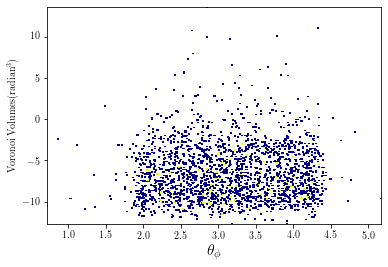

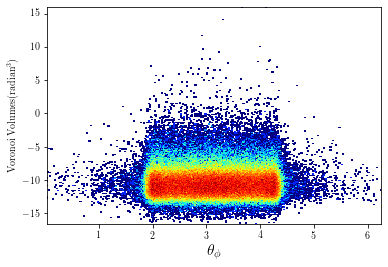

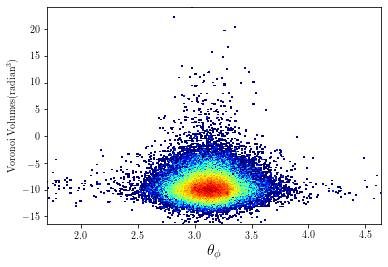

In [ ]:
#from matplotlib.colors import LogNorm
#plt.scatter(thetaphi_highKE_new, np.log(vor_vol_highKE), color='r', alpha=1, s=5)
#plt.plot(thetaphi_highKE_new, vor_vol_highKE,'o')
fig = plt.figure()
plt.hist2d(thetaphi_highKE_new, np.log(vor_vol_highKE), bins = (300,300), cmap=plt.cm.jet, norm=LogNorm())

#plt.ylim(0,1)
plt.xlabel(r'$\theta_\phi$', fontsize=16)
plt.ylabel('Voronoi Volumes(radian$^3$)')

#plt.yscale('log')
plt.savefig('vol_vs_thetaphi_highKE.pdf', bbox_inches = 'tight')
plt.show()


fig = plt.figure()
plt.hist2d(thetaphi_bkg_new, np.log(vor_vol_bkg), bins = (300,300), cmap=plt.cm.jet, norm=LogNorm())
#plt.plot(thetar_bkg_new, vor_vol_bkg,'o')
#plt.hist2d(thetaphi_highKE, theta_highKE, bins=(300, 300), cmap=plt.cm.jet, norm=LogNorm())
#plt.ylim(0,1)
plt.xlabel(r'$\theta_\phi$', fontsize=16)
plt.ylabel('Voronoi Volumes(radian$^3$)')

plt.savefig('vol_vs_thetaphi_bkg.pdf', bbox_inches = 'tight')
#plt.yscale('log')
plt.show()


fig = plt.figure()
plt.hist2d(thetaphi_real_new, np.log(vor_vol_real), bins = (300,300), cmap=plt.cm.jet, norm=LogNorm())

#plt.plot(thetar_real_new, vor_vol,'o')
#plt.hist2d(thetaphi_highKE, theta_highKE, bins=(300, 300), cmap=plt.cm.jet, norm=LogNorm())

#plt.ylim(0,1)
plt.xlabel(r'$\theta_\phi$', fontsize=16)
plt.ylabel('Voronoi Volumes(radian$^3$)')
plt.savefig('vol_vs_thetaphi_real.pdf', bbox_inches = 'tight')
#plt.yscale('log')
plt.show()

# Sorting and Cumulative Volume fraction for KS

In [ ]:
vor_vol_highKE = np.sort(np.array(vor_vol_highKE))
cuml_array_highKE = np.arange(1,len(vor_vol_highKE)+1, 1)
#cum_vor_vol = np.cumsum(vor_vol)/np.sum(vor_vol)
cuml_array_highKE = cuml_array_highKE/cuml_array_highKE[-1]

In [ ]:
vor_vol_bkg = np.sort(np.array(vor_vol_bkg))
cuml_array_bkg = np.arange(1,len(vor_vol_bkg)+1, 1)
#cum_vor_vol = np.cumsum(vor_vol)/np.sum(vor_vol)
cuml_array_bkg = cuml_array_bkg/cuml_array_bkg[-1]

In [ ]:
vor_vol_real = np.sort(np.array(vor_vol_real))
cuml_array_real = np.arange(1,len(vor_vol_real)+1, 1)
#cum_vor_vol = np.cumsum(vor_vol)/np.sum(vor_vol)
cuml_array_real = cuml_array_real/cuml_array_real[-1]

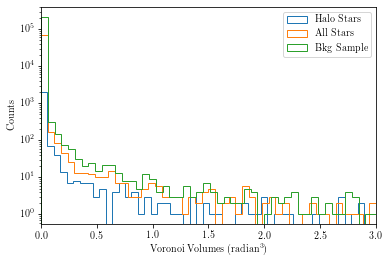

In [ ]:
# Plot cell volume distribution
plt.hist(vor_vol_highKE[0:-50], bins = 50, histtype='step', label = 'Halo Stars')
plt.hist(vor_vol_real[0:-185], bins = 50, histtype='step', label = 'All Stars')
plt.hist(vor_vol_bkg[0:-130], bins = 50, histtype='step', label = 'Bkg Sample')
plt.xlim(0,3)
#plt.ylim(0,200)
plt.yscale('log')
#plt.xscale('log')
plt.xlabel(r"Voronoi Volumes (radian$^3$)")
plt.ylabel("Counts")
plt.legend()
plt.savefig("voronoi_volumes.pdf")
plt.show()


In [ ]:
np.mean(vor_vol_real[0:-5])

160.14791906393543

In [ ]:
np.mean(vor_vol_bkg)

85.59081205128038

In [ ]:
np.mean(vor_vol_highKE)

442.69813397409456

In [ ]:
print(len(vor_vol_bkg))
print(len(cuml_array_bkg))
print(len(cuml_array_real))

217784
217784
72540


In [ ]:
vor_vol_bkg

array([5.89562657e-08, 6.24137980e-08, 6.82683410e-08, ...,
       1.26243603e+06, 8.33368833e+06, 8.84006932e+06])

In [ ]:
vor_vol_real

array([7.09503787e-08, 8.86005539e-08, 9.99789305e-08, ...,
       7.78307795e+08, 4.84319728e+09, 3.07533215e+10])

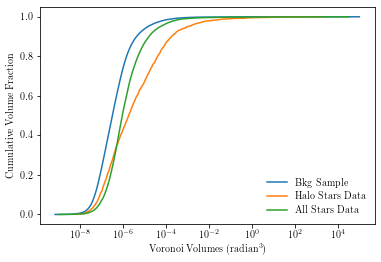

72540

In [ ]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.plot(vor_vol_bkg/np.mean(vor_vol_bkg), cuml_array_bkg, '-', label = 'Bkg Sample')
plt.plot(vor_vol_highKE/np.mean(vor_vol_highKE), cuml_array_highKE, '-', label = 'Halo Stars Data')
plt.plot(vor_vol_real[0:-6]/np.mean(vor_vol_real[0:-6]), cuml_array_real[0:-6], '-', label = 'All Stars Data')

#plt.xlim(0,0.0001)
#plt.title("Kolmogorov-Smirnov Statistic Test")
plt.xlabel("Voronoi Volumes (radian$^3$)")
plt.ylabel("Cumulative Volume Fraction")
plt.xscale('log')
plt.legend(frameon=False)
##plt.ylim(-0.0001,0.2)
plt.savefig("ks_test.pdf")
plt.show()

len(vor_vol_real)

In [ ]:
from scipy import stats
print(stats.ks_2samp(vor_vol_bkg, vor_vol_highKE))
print(stats.ks_2samp(vor_vol_real, vor_vol_highKE))
print(stats.ks_2samp(vor_vol_bkg, vor_vol_real))

Ks_2sampResult(statistic=0.5428049104089424, pvalue=0.0)
Ks_2sampResult(statistic=0.3998317984245674, pvalue=1.7018898208421282e-301)
Ks_2sampResult(statistic=0.22029478552094034, pvalue=0.0)
